# **Bottle-gourd Disease Detection using custom CNN models** 

In [15]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-3ikauknx
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-3ikauknx
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
import zipfile
import os
from tqdm import tqdm  # Import tqdm for progress bars

## Pre-Processing and Load the Dataset

In [17]:
# Define transformations with potential augmentations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),         
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/bottle-gourd/Bottle gourd", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Data Visualization for each class

['Anthracnose', 'Downey mildew', 'Fresh leaf']
{'Anthracnose': 0, 'Downey mildew': 1, 'Fresh leaf': 2}
3


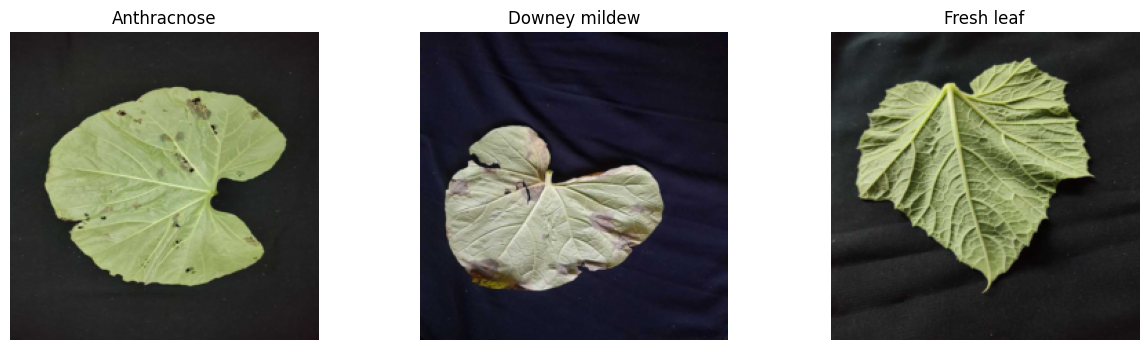

In [18]:
class_names = dataset.classes
print(class_names)
print(dataset.class_to_idx)
# Output: {'anthracnose': 0, 'downey mildew': 1, 'fresh leaf': 2}
num_classes = len(class_names)
print(num_classes)
fig, axs = plt.subplots(1, num_classes, figsize=(15, 4))
# Dictionary to track displayed images per class
displayed_classes = {class_name: False for class_name in class_names}

# Loop through the data to get at least one sample from each class
for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_name = class_names[label]
        # Display the image if not already displayed for this class
        if not displayed_classes[class_name]:
            img = img.permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  # Unnormalize the image
            axs[label].imshow(np.clip(img, 0, 1))  # Clip to valid range
            axs[label].set_title(class_name)
            axs[label].axis('off')
            displayed_classes[class_name] = True  # Mark as displayed

        # Break if all classes are displayed
        if all(displayed_classes.values()):
            break

    if all(displayed_classes.values()):
        break
plt.show()

## Define a Custom CNN model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 3)  # Change 3 → my number of classes
        
        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, start_dim=1)  # Dynamic flattening

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)

        return x


## Transfer Learning Model

In [20]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch.nn as nn
import timm

def get_transfer_model(model_name, num_classes):
    if model_name == "resnext101_32x8d":
        model = timm.create_model("resnext101_32x8d", pretrained=True)
        model.fc = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "densenet201":
        model = timm.create_model("densenet201", pretrained=True)
        model.classifier = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "efficientnetv2_s":
        model = timm.create_model("efficientnetv2_s", pretrained=True)
        model.classifier = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "nasnetalarge":
        model = timm.create_model("nasnetalarge", pretrained=True)
        model.last_linear = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "convnext_base":
        model = timm.create_model("convnext_base", pretrained=True)
        model.head = nn.Linear(model.get_classifier().in_features, num_classes)

    elif model_name == "xception":
        model = timm.create_model("xception", pretrained=True)
        model.fc = nn.Linear(model.get_classifier().in_features, num_classes)

    else:
        raise ValueError(f"Model '{model_name}' not supported. Please check the name.")

    return model


## Training and Early Stopping

In [22]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


# Train the Model and Plot Loss Curves

## Using AMP with Custom Model



To improve training speed, we can utilize Automatic Mixed Precision (AMP) provided by torch.cuda.amp. AMP enables faster training by using lower precision (float16) for parts of the computation while maintaining accuracy with some operations in higher precision (float32).

In [23]:
from tqdm import tqdm  # Import tqdm for progress bars
from torch.cuda.amp import autocast, GradScaler  # Import AMP utilities

# Set number of epochs and initialize variables

num_epochs = 50  # Define the number of training epochs

model = CustomCNN().to('cuda')  # Move model to GPU

criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Initialize GradScaler for AMP
scaler = GradScaler()
# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0  # Initialize cumulative training loss for the epoch
    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        optimizer.zero_grad()  # Clear previous gradients
        with autocast():  # Use AMP for mixed-precision calculations
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

        # Scale loss to avoid underflow for float16
        scaler.scale(loss).backward()  # Backward pass with scaled loss
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update the scaler for next iteration
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation
        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
            with autocast():  # Use AMP for mixed-precision calculations
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    progress = ((epoch + 1) / num_epochs) * 100
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} - Progress: {progress:.2f}%")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break



/tmp/ipykernel_31/3062821662.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_31/3062821662.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations
Validation:   0%|          | 0/12 [00:00<?, ?it/s]       /tmp/ipykernel_31/3062821662.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations


Epoch [1/50] - Train Loss: 1.0312, Val Loss: 0.9206 - Progress: 2.00%
Epoch 2/50


Epoch [2/50] - Train Loss: 0.8473, Val Loss: 0.7138 - Progress: 4.00%
Epoch 3/50


Epoch [3/50] - Train Loss: 0.6539, Val Loss: 0.6374 - Progress: 6.00%
Epoch 4/50


Epoch [4/50] - Train Loss: 0.4912, Val Loss: 0.4561 - Progress: 8.00%
Epoch 5/50


Epoch [5/50] - Train Loss: 0.4526, Val Loss: 0.5095 - Progress: 10.00%
Epoch 6/50


Epoch [6/50] - Train Loss: 0.4130, Val Loss: 0.4447 - Progress: 12.00%
Epoch 7/50


Epoch [7/50] - Train Loss: 0.3190, Val Loss: 0.2330 - Progress: 14.00%
Epoch 8/50


Epoch [8/50] - Train Loss: 0.1648, Val Loss: 0.1286 - Progress: 16.00%
Epoch 9/50


Epoch [9/50] - Train Loss: 0.1756, Val Loss: 0.1064 - Progress: 18.00%
Epoch 10/50


Epoch [10/50] - Train Loss: 0.0814, Val Loss: 0.0666 - Progress: 20.00%
Epoch 11/50


Epoch [11/50] - Train Loss: 0.0738, Val Loss: 0.0903 - Progress: 22.00%
Epoch 12/50


Epoch [12/50] - Train Loss: 0.0611, Val Loss: 0.0264 - Progress: 24.00%
Epoch 13/50


Epoch [13/50] - Train Loss: 0.0118, Val Loss: 0.0599 - Progress: 26.00%
Epoch 14/50


Epoch [14/50] - Train Loss: 0.5710, Val Loss: 0.2152 - Progress: 28.00%
Epoch 15/50


Epoch [15/50] - Train Loss: 0.1571, Val Loss: 0.1188 - Progress: 30.00%
Epoch 16/50


Epoch [16/50] - Train Loss: 0.0594, Val Loss: 0.0613 - Progress: 32.00%
Epoch 17/50


Epoch [17/50] - Train Loss: 0.0256, Val Loss: 0.0834 - Progress: 34.00%
Early stopping triggered.


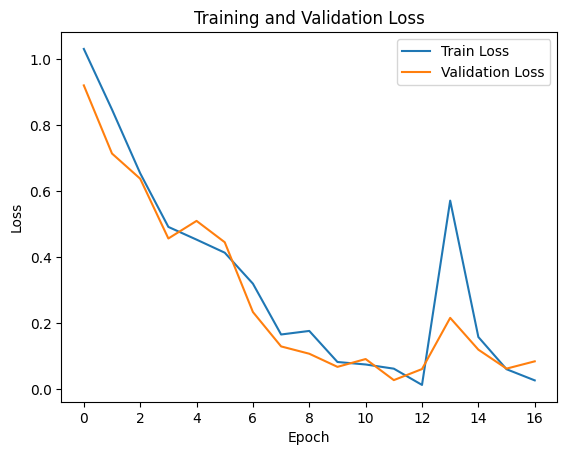

In [24]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [25]:
# Define a path for saving the model
model_save_path = "custom_cnn_model.pth"  # You can specify a different path or filename

# Save the model after training completes or early stopping is triggered
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to custom_cnn_model.pth


## Transfer Learning Example using ResNeXt101

In [26]:
from tqdm import tqdm  # Import tqdm for progress bars
from torch.cuda.amp import autocast, GradScaler  # Import AMP utilities

# Set number of epochs and initialize variables
num_epochs = 50  # Define the number of training epochs

model1 = get_transfer_model('resnext101_32x8d', num_classes).to('cuda')

criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Initialize GradScaler for AMP
scaler = GradScaler()
# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0  # Initialize cumulative training loss for the epoch
    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU

        optimizer.zero_grad()  # Clear previous gradients

        with autocast():  # Use AMP for mixed-precision calculations
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

        # Scale loss to avoid underflow for float16
        scaler.scale(loss).backward()  # Backward pass with scaled loss
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update the scaler for next iteration
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation
        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
            with autocast():  # Use AMP for mixed-precision calculations
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break



# Save the model
torch.save(model.state_dict(), 'transfer_learning_resnet101.pth')
print("Model saved as 'transfer_learning_resnet101.pth'")

/tmp/ipykernel_31/2332527498.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_31/2332527498.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations
Validation:   0%|          | 0/12 [00:00<?, ?it/s]       /tmp/ipykernel_31/2332527498.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations


Epoch [1/50] - Train Loss: 0.1990, Val Loss: 0.0328
Epoch 2/50


Epoch [2/50] - Train Loss: 0.0190, Val Loss: 0.0667
Epoch 3/50


Epoch [3/50] - Train Loss: 0.0481, Val Loss: 0.0212
Epoch 4/50


Epoch [4/50] - Train Loss: 0.0224, Val Loss: 0.0256
Epoch 5/50


Epoch [5/50] - Train Loss: 0.0091, Val Loss: 0.0673
Epoch 6/50


Epoch [6/50] - Train Loss: 0.0510, Val Loss: 0.0643
Epoch 7/50


Epoch [7/50] - Train Loss: 0.0184, Val Loss: 0.0399
Epoch 8/50


Epoch [8/50] - Train Loss: 0.0018, Val Loss: 0.0479
Early stopping triggered.
Model saved as 'transfer_learning_resnet101.pth'


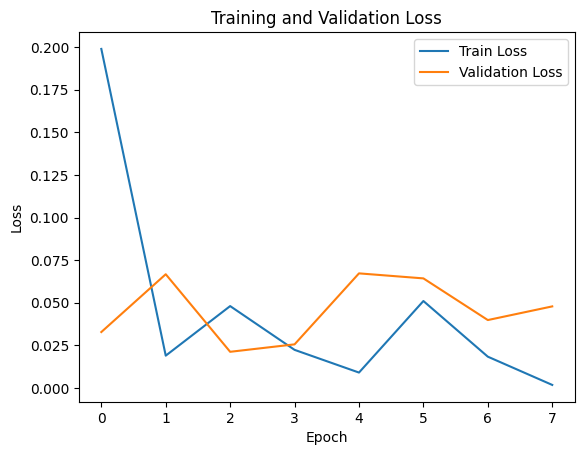

In [27]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

## Model Evaluation and Metrics Calculation

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Move model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():  # Disable gradient calculation for faster inference
    for images, labels in test_loader:
        # Move images and labels to the same device as the model (GPU)
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)

        # Get predictions (choose the class with the highest logit score)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels to lists
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())    # Move to CPU and convert to numpy

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 100.00%
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Move model to evaluation mode
model1.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():  # Disable gradient calculation for faster inference
    for images, labels in test_loader:
        # Move images and labels to the same device as the model (GPU)
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)

        # Get predictions (choose the class with the highest logit score)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels to lists
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())    # Move to CPU and convert to numpy

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 100.00%
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
